In [152]:
import math
import pickle as pkl
import cv2
import numpy as np
import random
import solution as sol
from PIL import Image, ImageDraw
import csv
import math
import matplotlib.pyplot as plt
random.seed(1)


def RANSACFilter(
        matched_pairs, keypoints1, keypoints2,
        orient_agreement, scale_agreement):
    """
    This function takes in `matched_pairs`, a list of matches in indices
    and return a subset of the pairs using RANSAC.
    Inputs:
        matched_pairs: a list of tuples [(i, j)],
            indicating keypoints1[i] is matched
            with keypoints2[j]
        keypoints1, 2: keypoints from image 1 and image 2
            stored in np.array with shape (num_pts, 4)
            each row: row, col, scale, orientation
        *_agreement: thresholds for defining inliers, floats
    Output:
        largest_set: the largest consensus set in [(i, j)] format

    HINTS: the "*_agreement" definitions are well-explained
           in the assignment instructions.
    """
    assert isinstance(matched_pairs, list)
    assert isinstance(keypoints1, np.ndarray)
    assert isinstance(keypoints2, np.ndarray)
    assert isinstance(orient_agreement, float)
    assert isinstance(scale_agreement, float)
    ## START
    ranint = random.radint(0,len(matched_pairs))
    largest_set = []
    ranint = random.randint(0,len(matched_pairs)-1)
    x1,y2 = matched_pairs[ranint]
    radian1 = keypoints1[x1][3]+keypoints2[y2][3]
    for i in range(0,10):
        ranint = random.randint(0,len(matched_pairs)-1)
        x,y = matched_pairs[ranint]
        radian = keypoints1[x][3]+keypoints2[y][3]
        diff = radian1 - radian
        if math.cos(radian-radian1)>math.cos(orient_agreement):
            matched_pairs.remove(matched_pairs[radint])
    ## END
    return matched_pairs

#이녀석 첫번째
def FindBestMatches(descriptors1, descriptors2, threshold):
    """
    This function takes in descriptors of image 1 and image 2,
    and find matches between them. See assignment instructions for details.
    Inputs:
        descriptors: a K-by-128 array, where each row gives a descriptor
        for one of the K keypoints.  The descriptor is a 1D array of 128
        values with unit length.
        threshold: the threshold for the ratio test of "the distance to the nearest"
                   divided by "the distance to the second nearest neighbour".
                   pseudocode-wise: dist[best_idx]/dist[second_idx] <= threshold
    Outputs:
        matched_pairs: a list in the form [(i, j)] where i and j means
                       descriptors1[i] is matched with descriptors2[j].
    """
    assert isinstance(descriptors1, np.ndarray)
    assert isinstance(descriptors2, np.ndarray)
    assert isinstance(threshold, float)
    ## START
    ## the following is just a placeholder to show you the output format
    shape1 = descriptors1.shape[0]
    shape2 = descriptors2.shape[0]
    match = {}
    matched_pairs=[]
    for i in range(shape1):
        for j in range(shape2):
            angle = math.acos(np.dot(descriptors1[i],descriptors2[j]))
            match[angle] = i,j
        match_list = sorted(match)
        f_neigh = match_list[0]
        s_neigh = match_list[1]
        ratio = f_neigh/s_neigh
        if ratio <= threshold:
            key1,key2 = match[f_neigh]
            matched_pairs.append([key1,key2])
        match = {}
#     distances = np.array(distances)
#     distances = distances.reshape(shape1,shape2)
#     indices1 = np.arange(descriptors1.shape[0])
#     indices2 = np.argmin(distances, axis=1)
#     best_distances = distances[indices1,indices2]
#     distances[indices1, indices2] = np.inf
#     second_best_indices2 = np.argmin(distances[indices1], axis=1)
#     second_best_distances = distances[indices1, second_best_indices2]
#     second_best_distances[second_best_distances == 0]=np.finfo(np.double).eps
#     ratio = best_distances / second_best_distances
#     mask = ratio < threshold
#     for i,j in zip(indices1[mask],indices2[mask]):
#        matched_pairs.append((i,j))
    ## END
    #matched_pairs=matched_pairs.tolist()
    return matched_pairs


def DisplayMatches(im1, im2, matched_pairs):
    """Display matches on a new image with the two input images placed side by side.

    Arguments:
     im1           1st image (in PIL 'RGB' format)
     im2           2nd image (in PIL 'RGB' format)
     matched_pairs list of matching keypoints, im1 to im2

    Displays and returns a newly created image (in PIL 'RGB' format)
    """
    im3 = AppendImages(im1,im2)
    offset = im1.size[0]
    draw = ImageDraw.Draw(im3)
    for match in matched_pairs:
        draw.line((match[0][1], match[0][0], offset+match[1][1], match[1][0]),fill="red",width=2)
    im3.show()
    return im3
def Match(image1, image2, ratio_thres):
    """
    Read two images and their associated SIFT keypoints and descriptors.
    Find matches between images based on acos distance.
    Display the final matches.
    HINT: See main_match.py on how to use this function.
    """
    im1, keypoints1, descriptors1 = ReadKeys(image1)
    im2, keypoints2, descriptors2 = ReadKeys(image2)

    matched_pairs = FindBestMatches(
        descriptors1, descriptors2, ratio_thres)
    matched_pairs = [
        [keypoints1[i], keypoints2[j]] for (i, j) in matched_pairs]
    assert len(matched_pairs) > 0, "No match received"
    
    im3 = DisplayMatches(im1, im2, matched_pairs)
    return im3
def AppendImages(im1, im2):
    """Create a new image that appends two images side-by-side.

    The arguments, im1 and im2, are PIL images of type RGB
    """
    im1cols, im1rows = im1.size
    im2cols, im2rows = im2.size
    im3 = Image.new('RGB', (im1cols+im2cols, max(im1rows,im2rows)))
    im3.paste(im1,(0,0))
    im3.paste(im2,(im1cols,0))
    return im3

def ReadKeys(image):
    """Input an image and its associated SIFT keypoints.

    The argument image is the image file name (without an extension).
    The image is read from the PGM format file image.pgm and the
    keypoints are read from the file image.key.

    ReadKeys returns the following 3 arguments:

    image: the image (in PIL 'RGB' format)

    keypoints: K-by-4 array, in which each row has the 4 values specifying
    a keypoint (row, column, scale, orientation).  The orientation
    is in the range [-PI, PI] radians.

    descriptors: a K-by-128 array, where each row gives a descriptor
    for one of the K keypoints.  The descriptor is a 1D array of 128
    values with unit length.
    """
    im = Image.open(image+'.pgm').convert('RGB')
    keypoints = []
    descriptors = []
    first = True
    with open(image+'.key','r') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC,skipinitialspace = True)
        descriptor = []
        for row in reader:
            if len(row) == 2:
                assert first, "Invalid keypoint file header."
                assert row[1] == 128, "Invalid keypoint descriptor length in header (should be 128)."
                count = row[0]
                first = False
            if len(row) == 4:
                keypoints.append(np.array(row))
            if len(row) == 20:
                descriptor += row
            if len(row) == 8:
                descriptor += row
                assert len(descriptor) == 128, "Keypoint descriptor length invalid (should be 128)."
                #normalize the key to unit length
                descriptor = np.array(descriptor)
                descriptor = descriptor / math.sqrt(np.sum(np.power(descriptor,2)))
                descriptors.append(descriptor)
                descriptor = []
    assert len(keypoints) == count, "Incorrect total number of keypoints read."
    print("Number of keypoints read:", int(count))
    descriptors = np.stack(descriptors, axis=0)
    return [im,keypoints,descriptors]

def FindBestMatchesRANSAC(
        keypoints1, keypoints2,
        descriptors1, descriptors2, threshold,
        orient_agreement, scale_agreement):
    """
    Note: you do not need to change this function.
    However, we recommend you to study this function carefully
    to understand how each component interacts with each other.

    This function find the best matches between two images using RANSAC.
    Inputs:
        keypoints1, 2: keypoints from image 1 and image 2
            stored in np.array with shape (num_pts, 4)
            each row: row, col, scale, orientation
        descriptors1, 2: a K-by-128 array, where each row gives a descriptor
        for one of the K keypoints.  The descriptor is a 1D array of 128
        values with unit length.
        threshold: the threshold for the ratio test of "the distance to the nearest"
                   divided by "the distance to the second nearest neighbour".
                   pseudocode-wise: dist[best_idx]/dist[second_idx] <= threshold
        orient_agreement: in degrees, say 30 degrees.
        scale_agreement: in floating points, say 0.5
    Outputs:
        matched_pairs_ransac: a list in the form [(i, j)] where i and j means
        descriptors1[i] is matched with descriptors2[j].
    Detailed instructions are on the assignment website
    """
    orient_agreement = float(orient_agreement)
    assert isinstance(keypoints1, np.ndarray)
    assert isinstance(keypoints2, np.ndarray)
    assert isinstance(descriptors1, np.ndarray)
    assert isinstance(descriptors2, np.ndarray)
    assert isinstance(threshold, float)
    assert isinstance(orient_agreement, float)
    assert isinstance(scale_agreement, float)
    matched_pairs = FindBestMatches(
        descriptors1, descriptors2, threshold)
    matched_pairs_ransac = RANSACFilter(
        matched_pairs, keypoints1, keypoints2,
        orient_agreement, scale_agreement)
    return matched_pairs_ransac
def MatchRANSAC(
        image1, image2, ratio_thres, orient_agreement, scale_agreement):
    """
    Read two images and their associated SIFT keypoints and descriptors.
    Find matches between images based on acos distance.
    Filter a subset of matches using RANSAC
    Display the final matches.
    HINT: See main_match.py on how to use this function.
    """
    im1, keypoints1, descriptors1 = ReadKeys(image1)
    im2, keypoints2, descriptors2 = ReadKeys(image2)

    keypoints1 = np.stack(keypoints1, axis=0)
    keypoints2 = np.stack(keypoints2, axis=0)
    matched_pairs = sol.FindBestMatchesRANSAC(
        keypoints1, keypoints2,
        descriptors1, descriptors2,
        ratio_thres, orient_agreement, scale_agreement)
    matched_pairs = [
        [keypoints1[i], keypoints2[j]] for (i, j) in matched_pairs]
    assert len(matched_pairs) > 0, "No match received"
    im3 = DisplayMatches(im1, im2, matched_pairs)
    return im3

In [19]:
import hw_utils as util
import numpy as np

In [23]:
im1, keypoints1, descriptors1 = ReadKeys('./data/scene')
im2, keypoints2, descriptors2 = ReadKeys('./data/basmati')
matched_pairs =  FindBestMatches(descriptors1,descriptors2,0.6)

Number of keypoints read: 694
Number of keypoints read: 579


In [154]:
plt.figure(figsize=(20, 20))
im = MatchRANSAC(
    './data/scene', './data/basmati',
    ratio_thres=0.6, orient_agreement=30, scale_agreement=0.5)
plt.title('MatchRANSAC')
plt.imshow(im)

Number of keypoints read: 694
Number of keypoints read: 579


AssertionError: 

<Figure size 1440x1440 with 0 Axes>

Number of keypoints read: 694
Number of keypoints read: 579


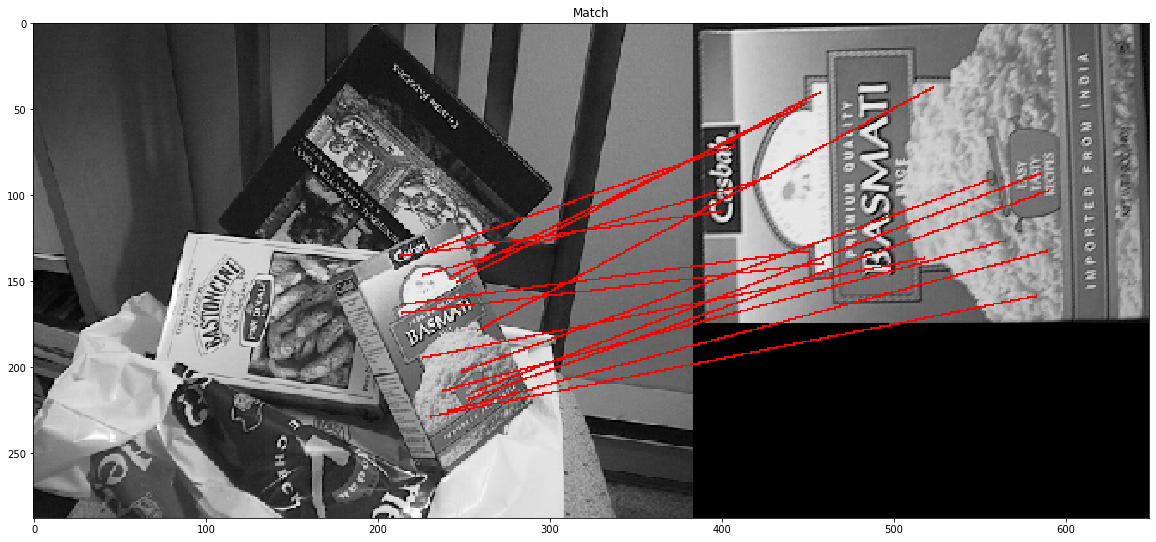

In [153]:
    # Test run matching with no ransac
    plt.figure(figsize=(20, 20))
    im =Match('./data/scene', './data/basmati', ratio_thres=0.6)
    plt.title('Match')
    plt.imshow(im)


In [ ]:
threshold=0.6
shape1 = descriptors1.shape[0]
shape2 = descriptors2.shape[0]
distances = []
matched_pairs=[]
for i in range(shape1):
    for j in range(shape2):
        distances.append(math.acos(sum(descriptors1[i]*descriptors2[j])))
distances = np.array(distances)
distances = distances.reshape(shape1,shape2)
indices1 = np.arange(descriptors1.shape[0])
indices2 = np.argmin(distances, axis=1)
best_distances = distances[indices1,indices2]
distances[indices1, indices2] = np.inf
second_best_indices2 = np.argmin(distances[indices1], axis=1)
second_best_distances = distances[indices1, second_best_indices2]
second_best_distances[second_best_distances == 0]=np.finfo(np.double).eps
ratio = best_distances / second_best_distances
mask = ratio < threshold
for i,j in zip(indices1[mask],indices2[mask]):
    matched_pairs.append([i,j])
## END

In [1]:
cv2.FindHomography(srcPoints, dstPoints, H, method=cv2.RANSAC, ransacReprojThreshold=tol)

NameError: name 'cv2' is not defined